In [1]:
# Importación de Librerias base

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Módulos de Scikit-learn para procesamiento y división

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Módulos de Scikit-learn para el modelo y métricas
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE 

print ("Librerias importadas correctamente")

Librerias importadas correctamente


In [ ]:
# Carga de datos

try:
    df=pd.read_csv("creditcard.csv")
    print("Dataset cargado exitosamente.")
except:
    print ("Error: El archivo 'creditcard.csv' no se encontró")
    print ("Asegurese de que el archivo esté en la misma carpeta que el notebook")
    
#EDA básico

if 'df' in locals():
    print(f"Forma del dataset: {df.shape}")
    print("\nDistribución de clases (Fraude = 1, No Fraude =0):")
    
    #Verificación del 0.172% de fraude
    print(df['Class'].value_counts(normalize=True))
    
    print("\nEstadisticas de la columna 'Amount'")
    print(df['Amount'].describe())

Dataser cargado exitosamente.
Forma del dataset: (284807, 31)

Distribución de clases (Fraude = 1, No Fraude =0):
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Estadisticas de la columna 'Amount'
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


In [3]:
# Separación de Features (X) y Target (Y)
# Se excluyen 'Time' y 'Class'

X= df.drop(columns=['Class','Time'])
Y = df['Class']

#División Train/Test

X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=0.2,
    stratify= Y,
    random_state=42
)

print(f"Tamaño Train: {X_train.shape}, Tamaño Test:{X_test.shape}")

#Escalado de datos
#Crítico para 'Amount' y las features 'Y'
scaler= StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

print("Datos escalados (StandardScaler)")

Tamaño Train: (227845, 29), Tamaño Test:(56962, 29)
Datos escalados (StandardScaler)


In [4]:
#Manejo del desbalance (SMOTE)
#Aplicar SMOTE solo al conjunto de entrenamiento

print("Aplicando SMOTE al conjunto de entrenamiento...")
sm = SMOTE(random_state=42)
X_res, Y_res= sm.fit_resample(X_train_scaled, Y_train)

print(f"Forma original de X_train: {X_train_scaled.shape}")
print(f"Forma re-muestreada (SMOTE) de X_train: {X_res.shape}")
print("\nDistribuición de clases despues de SMOTE:")
print (pd.Series(Y_res).value_counts(normalize=True))

Aplicando SMOTE al conjunto de entrenamiento...
Forma original de X_train: (227845, 29)
Forma re-muestreada (SMOTE) de X_train: (454902, 29)

Distribuición de clases despues de SMOTE:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [5]:
#Entrenamiento del Modelo: Red Neuronal (MLPClassifier)
print("Iniciando entranmiento del MLPClassifier...")

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(64, 32), #Arquitectura de dos capas
    max_iter=500,
    activation='relu',
    solver='adam',
    random_state=42,
    early_stopping=True,
    verbose=True
)

#Entrenamiento sobre los datos re-muestrados (SMOTE)

mlp_clf.fit(X_res,Y_res)

print("Entrenamiento del MLP finalizado.")

#Guardado del modelo entrenado

joblib.dump(mlp_clf,'modelo_mlp_fraude.joblib')
joblib.dump(scaler,'scaler_fraude.joblib')
print ("Modelo y Scaler gurdados en 'modelo_mlp_fraude.joblib' y 'scaler_fraude.joblib'")

Iniciando entranmiento del MLPClassifier...
Iteration 1, loss = 0.04348495
Validation score: 0.997736
Iteration 2, loss = 0.00600456
Validation score: 0.999253
Iteration 3, loss = 0.00369455
Validation score: 0.999319
Iteration 4, loss = 0.00285635
Validation score: 0.999494
Iteration 5, loss = 0.00223885
Validation score: 0.999604
Iteration 6, loss = 0.00215017
Validation score: 0.999604
Iteration 7, loss = 0.00165115
Validation score: 0.999406
Iteration 8, loss = 0.00196276
Validation score: 0.999538
Iteration 9, loss = 0.00151885
Validation score: 0.999363
Iteration 10, loss = 0.00139817
Validation score: 0.999428
Iteration 11, loss = 0.00141774
Validation score: 0.999472
Iteration 12, loss = 0.00142325
Validation score: 0.999692
Iteration 13, loss = 0.00118968
Validation score: 0.999648
Iteration 14, loss = 0.00132106
Validation score: 0.999758
Iteration 15, loss = 0.00113471
Validation score: 0.999604
Iteration 16, loss = 0.00126427
Validation score: 0.999714
Validation score did 


--- Evaluación del Modelo MLP sobre Datos de Prueba (Test) ---
AUC-ROC: 0.966686

Reporte de Clasificación (Umbral 0.5):
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00     56864
      Fraude       0.72      0.85      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962



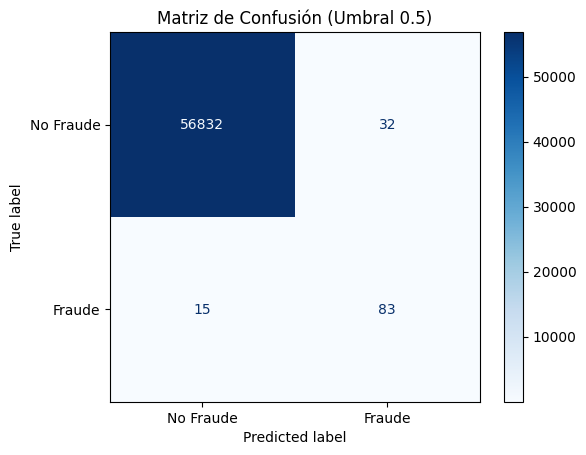

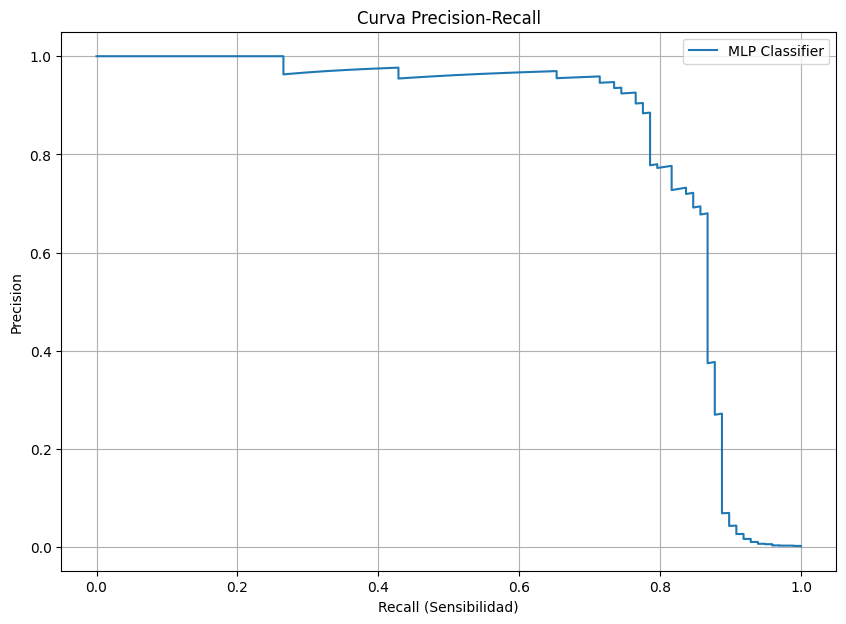

--- Fin de la Evaluación ---


In [6]:
#Evaluación (sobre el conjunto del test original, no balanceado)
print("\n--- Evaluación del Modelo MLP sobre Datos de Prueba (Test) ---")

y_proba_mlp= mlp_clf.predict_proba(X_test_scaled)[:,1]
y_pred_default = mlp_clf.predict(X_test_scaled)

#a) AUC-ROC
auc= roc_auc_score(Y_test, y_proba_mlp)
print(f"AUC-ROC: {auc:4f}")

#b) Reporte de Clasificación (Umbral 0.5)
print("\nReporte de Clasificación (Umbral 0.5):")
print(classification_report(Y_test, y_pred_default, target_names=['No Fraude','Fraude']))

#c) Matriz de Confusión (Umbral 0.5)
cm = confusion_matrix(Y_test, y_pred_default)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fraude', 'Fraude'])
disp.plot (cmap='Blues')
plt.title('Matriz de Confusión (Umbral 0.5)')
plt.show()

#d) Curva Precisión-Recall
#Esta es la curva más relevante para data desbalanceada

precision,recall, tresholds= precision_recall_curve(Y_test, y_proba_mlp)

plt.figure(figsize=(10,7))
plt.plot(recall,precision,label='MLP Classifier')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

print("--- Fin de la Evaluación ---")

Generación de Datos de Fraude

In [7]:
import random 

# (Asegúrese de que 'X_test' y 'Y_test' (con Y mayúscula) existan en la memoria)

try:
    # 1. Obtener todos los índices de transacciones 'Fraude' (Y_test == 1)
    indices_fraude = Y_test[Y_test == 1].index
    
    if len(indices_fraude) == 0:
        print("Error: No se encontraron fraudes en su 'Y_test'.")
    else:
        # 2. Elegir un índice al azar de esa lista
        indice_aleatorio = random.choice(indices_fraude)
        
        # 3. Obtener los datos de esa transacción desde X_test
        datos_fraude = X_test.loc[indice_aleatorio]
        
        # 4. Convertir los 29 números en un string
        string_fraude = ','.join(datos_fraude.astype(str).values)
        
        print("--- CADENA DE 'FRAUDE' REAL (DE X_TEST) ---")
        print("Copie la línea de abajo y péguela en la celda interactiva:")
        print("(Puede ejecutar esta celda varias veces para obtener ejemplos diferentes)")
        print("\n")
        print(string_fraude)

except NameError:
    print("Error: Las variables 'X_test' o 'Y_test' no se encontraron.")
    print("Asegúrese de ejecutar primero la celda de 'División Train/Test'.")
except Exception as e:
    print(f"Un error inesperado ocurrió: {e}")

--- CADENA DE 'FRAUDE' REAL (DE X_TEST) ---
Copie la línea de abajo y péguela en la celda interactiva:
(Puede ejecutar esta celda varias veces para obtener ejemplos diferentes)


-2.3122265423263,1.95199201064158,-1.60985073229769,3.9979055875468,-0.522187864667764,-1.42654531920595,-2.53738730624579,1.39165724829804,-2.77008927719433,-2.77227214465915,3.20203320709635,-2.89990738849473,-0.595221881324605,-4.28925378244217,0.389724120274487,-1.14074717980657,-2.83005567450437,-0.0168224681808257,0.416955705037907,0.126910559061474,0.517232370861764,-0.0350493686052974,-0.465211076182388,0.320198198514526,0.0445191674731724,0.177839798284401,0.261145002567677,-0.143275874698919,0.0


Generación de datos NO FRAUDES

In [56]:
import random 

# (Asegúrese de que 'X_test' y 'Y_test' (con Y mayúscula) existan en la memoria)

try:
    # 1. Obtener todos los índices de transacciones 'No Fraude' (Y_test == 0)
    indices_no_fraude = Y_test[Y_test == 0].index
    
    # 2. Elegir un índice al azar de esa lista
    indice_aleatorio = random.choice(indices_no_fraude)
    
    # 3. Obtener los datos de esa transacción desde X_test
    datos_no_fraude = X_test.loc[indice_aleatorio]
    
    # 4. Convertir los 29 números en un string
    string_no_fraude = ','.join(datos_no_fraude.astype(str).values)
    
    print("--- CADENA DE 'NO FRAUDE' REAL (DE X_TEST) ---")
    print("Copie la línea de abajo y péguela en la celda interactiva:")
    print("(Puede ejecutar esta celda varias veces para obtener ejemplos diferentes)")
    print("\n")
    print(string_no_fraude)

except NameError:
    print("Error: Las variables 'X_test' o 'Y_test' no se encontraron.")
    print("Asegúrese de ejecutar primero la celda de 'División Train/Test'.")
except Exception as e:
    print(f"Un error inesperado ocurrió: {e}")

--- CADENA DE 'NO FRAUDE' REAL (DE X_TEST) ---
Copie la línea de abajo y péguela en la celda interactiva:
(Puede ejecutar esta celda varias veces para obtener ejemplos diferentes)


-0.855575128693034,-0.100130500895429,-0.303667595535437,-0.329374191798502,1.0126057275137,0.411710008554775,1.26120800078087,-0.1972657856417,0.617687955855975,-0.816793624570537,0.149362873598034,0.311329553556984,-0.776424270636675,-1.76751120234073,-2.5083665279137,-0.0687660659242498,0.620187737132499,0.178047247478828,0.724656741833659,-0.424186270234371,-0.43669663380021,-0.465207443513433,0.533170023020923,0.13354918768231,-0.863009415485152,0.0718046930480881,-0.0246230872109141,-0.0767729246170503,130.68


In [8]:

import joblib
import numpy as np

# --- 1. Cargar Artefactos ---
try:
    model = joblib.load('modelo_mlp_fraude.joblib')
    scaler = joblib.load('scaler_fraude.joblib')
    print("Modelo y Scaler cargados exitosamente.")
except FileNotFoundError:
    print("Error: No se encontraron los archivos .joblib.")
    

Modelo y Scaler cargados exitosamente.


In [9]:
# --- 2. Función de Inferencia (CORREGIDA) ---
def predecir_transaccion(transaccion_data, scaler_cargado, model_cargado, umbral=0.20):
    
    if len(transaccion_data) != 29:
        return f"Error: Se esperaban 29 características, pero se recibieron {len(transaccion_data)}."
    
    # --- CAMBIO 2: RECONSTRUIR EL DATAFRAME CON NOMBRES ---
    # Definir los 29 nombres de columnas exactos
    feature_names = [f'V{i}' for i in range(1, 29)] + ['Amount']
    
    # Convertir la lista de entrada en un DataFrame de 1 fila CON los nombres
    transaccion_df = pd.DataFrame([transaccion_data], columns=feature_names)
    # ---------------------------------------------------
    
    try:
        # --- CAMBIO 3: Escalar el DataFrame (no el array) ---
        transaccion_escalada = scaler_cargado.transform(transaccion_df)
        
    except Exception as e:
        return f"Error al escalar datos: {e}" 
        
    # El resto de la predicción funciona igual
    probabilidades = model_cargado.predict_proba(transaccion_escalada)
    prob_fraude = probabilidades[0][1]
    
    if prob_fraude > umbral:
        return f"🚨 ¡FRAUDE DETECTADO! (Confianza: {prob_fraude:.2%}, Umbral: {umbral:.0%})"
    else:
        return f"✅ Transacción Normal (Probabilidad de Fraude: {prob_fraude:.2%}, Umbral: {umbral:.0%})"

# --- 3. Lógica de Entrada Interactiva (Sin cambios) ---
print("\n--- Sistema de Prueba de Inferencia (Formato Corregido) ---")
print("Pegue la cadena de 29 números (V1-V28, Amount) separados por comas:")
print("(Busque la caja de entrada en la PARTE SUPERIOR de VS Code)")

datos_input = input()

try:
    transaccion_lista = [float(valor.strip()) for valor in datos_input.split(',')]
    
    if 'model' in locals() and 'scaler' in locals():
        resultado = predecir_transaccion(transaccion_lista, scaler, model)
        print("\n--- VEREDICTO ---")
        print(resultado)
    else:
        print("Error: El modelo o el scaler no se cargaron correctamente.")

except ValueError:
    print("\nError: Formato inválido. Asegúrese de ingresar solo números separados por comas.")
except Exception as e:
    print(f"\nUn error inesperado ocurrió: {e}")


--- Sistema de Prueba de Inferencia (Formato Corregido) ---
Pegue la cadena de 29 números (V1-V28, Amount) separados por comas:
(Busque la caja de entrada en la PARTE SUPERIOR de VS Code)

--- VEREDICTO ---
🚨 ¡FRAUDE DETECTADO! (Confianza: 100.00%, Umbral: 20%)
